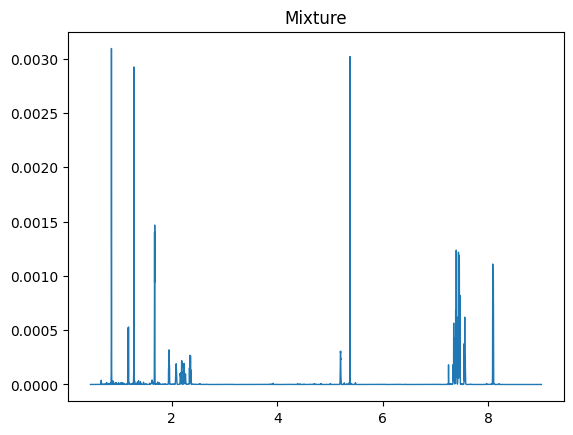

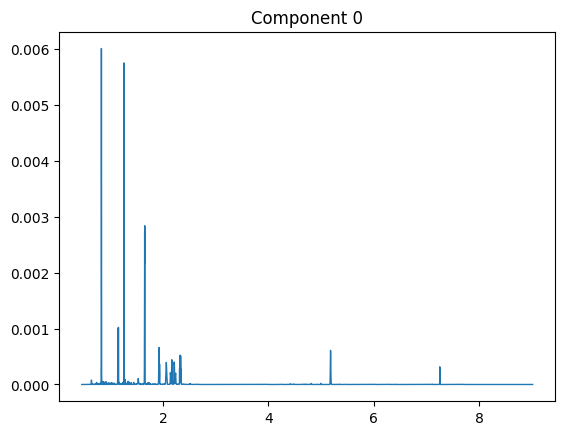

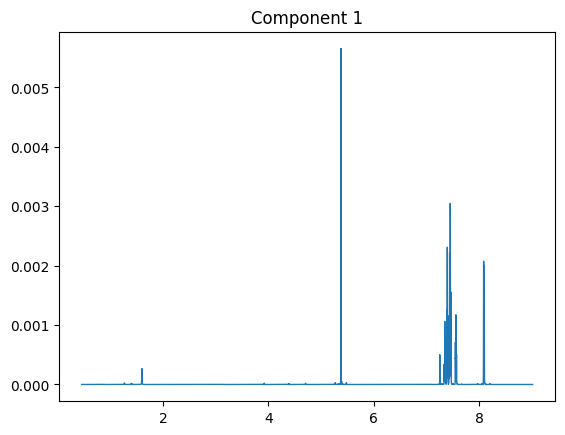

[(np.float64(0.457009), np.float64(1.528229306820996e-07)), (np.float64(0.457131), np.float64(1.2123352302240056e-07)), (np.float64(0.457253), np.float64(1.1059162033064253e-07)), (np.float64(0.457374), np.float64(9.99725490432446e-08)), (np.float64(0.457496), np.float64(9.365442068531171e-08)), (np.float64(0.457618), np.float64(8.733629232737883e-08)), (np.float64(0.457739), np.float64(1.2403407244641448e-07)), (np.float64(0.457861), np.float64(1.6073185256545014e-07)), (np.float64(0.457982), np.float64(2.3614336410202387e-07)), (np.float64(0.458104), np.float64(2.427302242599255e-07))]


In [4]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from wasserstein import Spectrum, NMRSpectrum

# Import sparse utilities
sys.path.append(os.path.abspath("."))
from test_utils import (
    UtilsSparse, 
    multidiagonal_cost, 
    warmstart_sparse, 
    reg_distribiution,
    signif_features,
    load_data
)

from typing import List
from matplotlib import pyplot as plt

import numpy as np
from tqdm import trange

components_names = ["Pinene", "Benzyl benzoate"]

protons_list = [16, 12]

filename = "preprocessed_mix.csv"
mix = np.loadtxt(filename, delimiter=",")
# If you are using file exported from Mnova, comment line above and uncomment line below.
# mix = np.loadtxt(filename, delimiter='\t', usecols=[0,1])

how_many_components = len(components_names)
names = ["comp" + str(i) for i in range(how_many_components)]

files_with_components = ["preprocessed_comp0.csv", "preprocessed_comp1.csv"]
spectra = []
for i in range(how_many_components):
    filename = files_with_components[i]
    spectra.append(np.loadtxt(filename, delimiter=","))
    # If you are using file exported from Mnova, comment line above and uncomment line below.
    # spectra.append(np.loadtxt(filename, delimiter='\t', usecols=[0,1]))

spectra2: List[NMRSpectrum] = []
names = []
for i in range(len(spectra)):
    spectra2.append(
        NMRSpectrum(
            confs=list(zip(spectra[i][:, 0], spectra[i][:, 1])), protons=protons_list[i]
        )
    )
    names.append("comp" + str(i))

spectra = spectra2
del spectra2
mix = NMRSpectrum(confs=list(zip(mix[:, 0], mix[:, 1])))
mix.trim_negative_intensities()
mix.normalize()
for sp in spectra:
    sp.trim_negative_intensities()
    sp.normalize()
plt.title("Mixture")
mix.plot(profile=True)
for i, sp in enumerate(spectra):
    plt.title("Component " + str(i))
    sp.plot(profile=True)
print(spectra[0].confs[:10])


In [ ]:
from scipy.sparse import dia_matrix


def loss_sparse(
    mix, sp, C, reg, reg_m1, reg_m2, damp, numIter=1000, step=0.001, warmstart=None
):
    # extract marginals & locations
    a = np.array([pi for _, pi in mix.confs])
    v1 = np.array([v for v, _ in mix.confs])
    b = np.array([pi for _, pi in sp.confs])
    v2 = np.array([v for v, _ in sp.confs])

    # cost & reference
    M = multidiagonal_cost(v1, v2, C)
    if warmstart is None:
        warmstart = warmstart_sparse(a, b, C)
    c = reg_distribiution(len(mix.confs), C)

    # run sparse mirror‐descent
    sparse = UtilsSparse(a, b, c, warmstart, M, reg, reg_m1, reg_m2)
    G, log = sparse.mirror_descent_unbalanced(numItermax=numIter, step_size=step)

    # rebuild the full objective
    transport_cost = sparse.sparse_dot(G, sparse.offsets)
    marginal_penalty = sparse.marg_tv_sparse(G, sparse.offsets)
    final_dist = transport_cost + marginal_penalty / (reg_m1 + reg_m2) * damp

    # return distance _and_ the padded‐diagonals for warm‐starting next time
    return final_dist, G


def mirror_descent_two_weights_sparse(
    mix,
    comp0,
    comp1,
    lr=0.2,
    T=50,
    C=15,
    reg=1.5,
    reg_m1=200,
    reg_m2=200,
    damp=1.0,
    numIter=400,
    step=0.001,
):
    # pick out your peaks just once
    N_mix = len(mix.confs)
    offsets = np.arange(-C + 1, C)
    matrix_shape = (N_mix, N_mix)

    p = np.array([0.5, 0.5])
    hist = [p.copy()]
    scores = []

    # no warmstart on the first call
    warm = None

    for _ in trange(T, desc="Sparse MD (2 weights)"):
        # build current mix
        sp = Spectrum.ScalarProduct([comp0, comp1], p)
        sp.normalize()

        # 1) solve & get back the padded‐diagonals G_data
        dist, G_data = loss_sparse(
            mix,
            sp,
            C,
            reg,
            reg_m1,
            reg_m2,
            damp,
            numIter=numIter,
            step=step,
            warmstart=warm,
        )
        scores.append(dist)

        # 2) rebuild warmstart as a dia_matrix for next iteration
        warm = dia_matrix((G_data, offsets), shape=matrix_shape)

        # 3) finite‐difference gradient
        eps = 1e-6
        p_plus = np.clip([p[0] + eps, p[1] - eps], 1e-6, 1)
        p_plus /= p_plus.sum()
        p_minus = np.clip([p[0] - eps, p[1] + eps], 1e-6, 1)
        p_minus /= p_minus.sum()

        # two solves _with_ warm restart
        sp_p = Spectrum.ScalarProduct([comp0, comp1], p_plus)
        sp_p.normalize()
        sp_m = Spectrum.ScalarProduct([comp0, comp1], p_minus)
        sp_m.normalize()

        Lp, _ = loss_sparse(
            mix,
            sp_p,
            C,
            reg,
            reg_m1,
            reg_m2,
            damp,
            numIter=numIter,
            step=step,
            warmstart=warm,
        )
        Lm, _ = loss_sparse(
            mix,
            sp_m,
            C,
            reg,
            reg_m1,
            reg_m2,
            damp,
            numIter=numIter,
            step=step,
            warmstart=warm,
        )

        g = (Lp - Lm) / (2 * eps)

        # mirror‐descent weight update
        w = p * np.exp(-lr * np.array([g, -g]))
        p = w / w.sum()

        hist.append(p.copy())

    return p, np.array(hist), np.array(scores)


N = 600
spectra_signif = [None] * 2
spectra_signif[0] = signif_features(spectra[0], N)
spectra_signif[1] = signif_features(spectra[1], N)
mix_signif = signif_features(mix, 2 * N)


final_p, traj, score_history = mirror_descent_two_weights_sparse(
    mix_signif, spectra_signif[0], spectra_signif[1]
)


Sparse MD (2 weights): 100%|██████████| 50/50 [10:35<00:00, 12.70s/it]



Final weights:
  comp1 = 0.4844
  comp2 = 0.5156


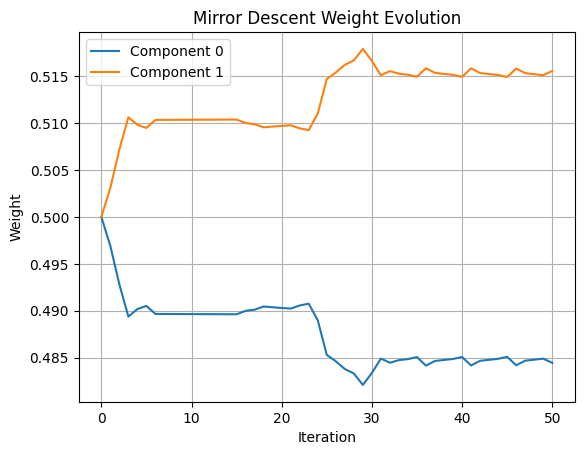

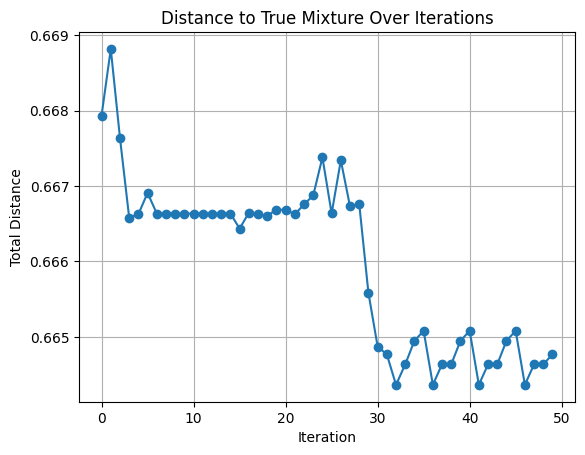

In [12]:
print("\nFinal weights:")
print(f"  comp1 = {final_p[0]:.4f}")
print(f"  comp2 = {final_p[1]:.4f}")

plt.plot(traj[:, 0], label="Component 0")
plt.plot(traj[:, 1], label="Component 1")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.title("Mirror Descent Weight Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(score_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Total Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()
